In [23]:
# Importing necessary libraries for EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

# Importing libraries necessary for Model Building and Training
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
data = pd.read_csv('emails.csv')
data.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [25]:
data.shape

(5728, 2)

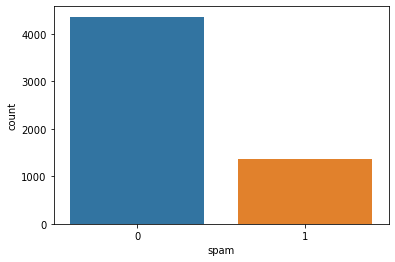

In [26]:
sns.countplot(x='spam', data=data)
plt.show()

In [27]:
ham_msg = data[data.spam == 0]
spam_msg = data[data.spam == 1]
ham_msg = ham_msg.sample(n=len(spam_msg),random_state=42)

Text(0.5, 0, 'Message types')

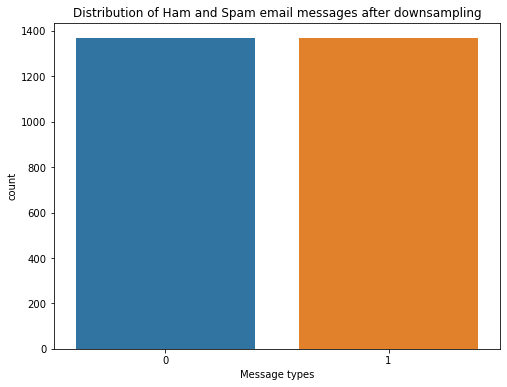

In [28]:
balanced_data = pd.concat([ham_msg, spam_msg], ignore_index=True)
plt.figure(figsize=(8, 6))
sns.countplot(data=balanced_data, x='spam')
plt.title('Distribution of Ham and Spam email messages after downsampling')
plt.xlabel('Message types')

In [29]:
balanced_data['text'] = balanced_data['text'].str.replace('Subject', '')
balanced_data.head()

,text,spam
0,: interview schedule for jinbaek kim i didn '...,0
1,": re : wednesday meeting eric , i think we c...",0
2,: re : london research group i ' d do it as s...,0
3,": re : congratulations vince , thanks for you...",0
4,: osman sezgen steve kromer is requesting tha...,0


In [30]:
punctuations_list = string.punctuation
def remove_punctuations(text):
	temp = str.maketrans('', '', punctuations_list)
	return text.translate(temp)

balanced_data['text']= balanced_data['text'].apply(lambda x: remove_punctuations(x))
balanced_data.head()

,text,spam
0,interview schedule for jinbaek kim i didn t...,0
1,re wednesday meeting eric i think we can ...,0
2,re london research group i d do it as soon...,0
3,re congratulations vince thanks for your n...,0
4,osman sezgen steve kromer is requesting that...,0


In [32]:
def remove_stopwords(text):
	stop_words = stopwords.words('english')

	imp_words = []

	# Storing the important words
	for word in str(text).split():
		word = word.lower()

		if word not in stop_words:
			imp_words.append(word)

	output = " ".join(imp_words)

	return output

balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))
balanced_data.head()

,text,spam
0,interview schedule jinbaek kim see went happy ...,0
1,wednesday meeting eric think skip meeting disc...,0
2,london research group soon possible call exact...,0
3,congratulations vince thanks note congratulati...,0
4,osman sezgen steve kromer requesting osman spe...,0


In [33]:
#train test split
train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['text'],balanced_data['spam'],test_size = 0.2,random_state = 42)

In [37]:
# Tokenize the text data
from keras_preprocessing.sequence import pad_sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

# Pad sequences to have the same length
max_len = 100 # maximum sequence length
train_sequences = pad_sequences(train_sequences,
								maxlen=max_len, 
								padding='post', 
								truncating='post')
test_sequences = pad_sequences(test_sequences, 
							maxlen=max_len, 
							padding='post', 
							truncating='post')

In [38]:
# Build the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1,
                                    output_dim=32, 
                                    input_length=max_len))
model.add(tf.keras.layers.LSTM(16, return_sequences=True))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           805024    
                                                                 
 lstm (LSTM)                 (None, 100, 16)           3136      
                                                                 
 lstm_1 (LSTM)               (None, 16)                2112      
                                                                 
 dense (Dense)               (None, 64)                1088      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 813,473
Trainable params: 813,473
Non-trai

In [39]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
			metrics = ['accuracy'],
			optimizer = 'adam')

In [40]:
es = EarlyStopping(patience=3,
				monitor = 'val_accuracy',
				restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
					monitor = 'val_loss',
					factor = 0.5,
					verbose = 0)
log_dir = "logs/fit"  # Tentukan direktori untuk menyimpan log TensorBoard
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


In [41]:

# Train the model
history = model.fit(train_sequences, train_Y,validation_data=(test_sequences, test_Y),epochs=20,batch_size=32,callbacks = [tensorboard_callback, lr, es])

Epoch 1/20
69/69 [==============================] - 12s 98ms/step - loss: 0.5360 - accuracy: 0.7258 - val_loss: 0.2453 - val_accuracy: 0.9489 - lr: 0.0010
Epoch 2/20
69/69 [==============================] - 4s 63ms/step - loss: 0.1065 - accuracy: 0.9785 - val_loss: 0.2084 - val_accuracy: 0.9580 - lr: 0.0010
Epoch 3/20
69/69 [==============================] - 4s 53ms/step - loss: 0.0671 - accuracy: 0.9872 - val_loss: 0.1794 - val_accuracy: 0.9672 - lr: 0.0010
Epoch 4/20
69/69 [==============================] - 4s 56ms/step - loss: 0.0822 - accuracy: 0.9840 - val_loss: 0.2330 - val_accuracy: 0.9471 - lr: 0.0010
Epoch 5/20
69/69 [==============================] - 4s 54ms/step - loss: 0.1068 - accuracy: 0.9758 - val_loss: 0.1039 - val_accuracy: 0.9781 - lr: 0.0010
Epoch 6/20
69/69 [==============================] - 4s 52ms/step - loss: 0.0378 - accuracy: 0.9936 - val_loss: 0.1124 - val_accuracy: 0.9781 - lr: 0.0010
Epoch 7/20
69/69 [==============================] - 4s 52ms/step - loss: 0.

In [42]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

In [43]:
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

18/18 [==============================] - 0s 19ms/step - loss: 0.1039 - accuracy: 0.9781
Test Loss : 0.10387089103460312
Test Accuracy : 0.9781022071838379


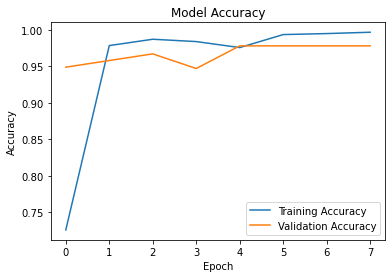

In [44]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()